# No-glue-code

In [1]:
using Pkg
Pkg.activate("..")

  Activating project at `~/Cambdrige`


In [2]:
# The statistical inference frame-work we will use
using LogDensityProblems
using LogDensityProblemsAD
using DynamicPPL
using ForwardDiff
using Random
using LinearAlgebra

#Plotting
using PyPlot

#What we are tweaking
using Revise
using AdvancedHMC
using Turing

[ Info: Precompiling AdvancedHMC [0bf59076-c3b1-5ca4-86bd-e02cd72cde3d]
[ Info: Precompiling Turing [fce5fe82-541a-59a6-adf8-730c64b5f9a0]


## Model

In [3]:
# Just a simple Neal Funnel
d = 21
@model function funnel()
    θ ~ Normal(0, 3)
    z ~ MvNormal(zeros(d-1), exp(θ)*I)
    x ~ MvNormal(z, I)
end

funnel (generic function with 2 methods)

In [4]:
Random.seed!(1)
(;x) = rand(funnel() | (θ=0,))
funnel_model = funnel() | (;x)

Model{typeof(funnel), (), (), (), Tuple{}, Tuple{}, ConditionContext{NamedTuple{(:x,), Tuple{Vector{Float64}}}, DefaultContext}}(funnel, NamedTuple(), NamedTuple(), ConditionContext((x = [1.2142074831535152, 1.23371919965455, -0.8480146960461767, 0.1600994648479841, 1.9180385508479283, -3.401523464506408, -0.0957684186471088, 0.6734622629464286, -3.2749467689509633, -1.6760091758453226, 1.9567202902549736, 0.1136169088905351, 0.11117896909388916, -0.5373922347882832, -0.12436857036298687, -1.2901071061088532, 1.702584517514787, -0.44460133117954226, 1.0818722439221686, 1.2208011493237483],), DefaultContext()))

## Turing interface

In [31]:
struct Sampler
    metric
    integrator
    adaptor
    proposal
end

Sampler(ϵ::Number, TAP::Number) = begin
    metric =  DiagEuclideanMetric(d)
    integrator = Leapfrog(ϵ)
    proposal = AdvancedHMC.NUTS{MultinomialTS, GeneralisedNoUTurn}(integrator)
    adaptor = StanHMCAdaptor(MassMatrixAdaptor(metric), StepSizeAdaptor(TAP, integrator))
    
    Sampler(
        metric,
        integrator,
        adaptor,
        proposal)
end

Sampler

In [32]:
initial_θ = randn(21)
initial_ϵ = 0.1 #find_good_stepsize(hamiltonian, initial_θ)
spl = Sampler(initial_ϵ, 0.95)

LoadError: TypeError: in Type{...} expression, expected UnionAll, got Type{AdvancedHMC.NUTS}

### Sampling

In [ ]:
n_samples, n_adapts = 10_000, 1_000
samples, stats = sample(funnel_model, 0.1, 0.95, n_samples, n_adapts; initial_θ=initial_θ);

LoadError: TypeError: in Type{...} expression, expected UnionAll, got Type{AdvancedHMC.NUTS}

### Plotting

In [ ]:
theta_mchmc = [sample[1] for sample in samples]
x10_mchmc = [sample[10+1] for sample in samples];

LoadError: UndefVarError: `samples` not defined

In [ ]:
fig, axis = plt.subplots(2, 2, figsize=(8,8))
fig.suptitle("Neal's Funnel", fontsize=16)

fig.delaxes(axis[1,2])
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)

axis[1,1].hist(x10_mchmc, bins=100, range=[-6,2])
axis[1,1].set_yticks([])

axis[2,2].hist(theta_mchmc, bins=100, orientation="horizontal", range=[-4, 2])
axis[2,2].set_xticks([])
axis[2,2].set_yticks([])

axis[2,1].hist2d(x10_mchmc, theta_mchmc, bins=100, range=[[-6,2],[-4, 2]])
axis[2,1].set_xlabel("x10")
axis[2,1].set_ylabel("theta");

LoadError: UndefVarError: `x10_mchmc` not defined

## Sampling w AbstractMCMC

In [33]:
using MCMCChains

nadapts=500 
TAP=0.95
nuts = AdvancedHMC.NUTS(nadapts, TAP; init_ϵ=0.1)

AdvancedHMC.NUTS(500, 0.95, 10, 1000.0, 0.1, nothing, Leapfrog, AdvancedHMC.NUTS_kernel{MultinomialTS, GeneralisedNoUTurn}, AdvancedHMC.var"#adaptor#38"{Float64}(0.95))

In [37]:
Asamples = sample(funnel_model, nuts, 5000; chain_type=MCMCChains.Chains)

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter ~/.julia/packages/ProgressMeter/sN2xr/src/ProgressMeter.jl:618
Sampling 100%|███████████████████████████████| Time: 0:00:02
  iterations:                                   5000
  ratio_divergent_transitions:                  0.0
  ratio_divergent_transitions_during_adaption:  0.0
  n_steps:                                      31
  is_accept:                                    true
  acceptance_rate:                              0.9972711825204867
  log_density:                                  -66.96166284016837
  hamiltonian_energy:                           77.91847431602888
  hamiltonian_energy_error:                     0.003880195070948389
  max_hamilto

Chains MCMC chain (5000×34×1 Array{Real, 3}):

Iterations        = 1:1:5000
Number of chains  = 1
Samples per chain = 5000
parameters        = θ, z1, z2, z3, z4, z5, z6, z7, z8, z9, z10, z11, z12, z13, z14, z15, z16, z17, z18, z19, z20
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size, is_adapt

Summary Statistics
  parameters      mean       std      mcse     ess_bulk      rhat   ess_per_se ⋯
      Symbol   Float64   Float64   Float64         Real   Float64       Missin ⋯

           θ   -0.1142    0.9101    0.0586     438.4964    1.0030       missin ⋯
          z1    0.5951    0.7297    0.0125    3573.6057    1.0001       missin ⋯
          z2    0.5975    0.7256    0.0127    3211.0596    1.0002       missin ⋯
          z3   -0.4172    0.7031    0.0102    4921.0006    1.0003       missin ⋯
          z4    0.0834    0.6897    0.0066 

┌ Warning: Tail ESS calculation failed: OverflowError("4750 * 4503599627370496 overflowed for type Int64")
└ @ MCMCChains ~/.julia/packages/MCMCChains/OVsxE/src/stats.jl:319


### Plotting

In [38]:
theta_mchmc = Vector(Asamples["θ"][:, 1])
x10_mchmc =Vector(Asamples["z10"][:, 1]);

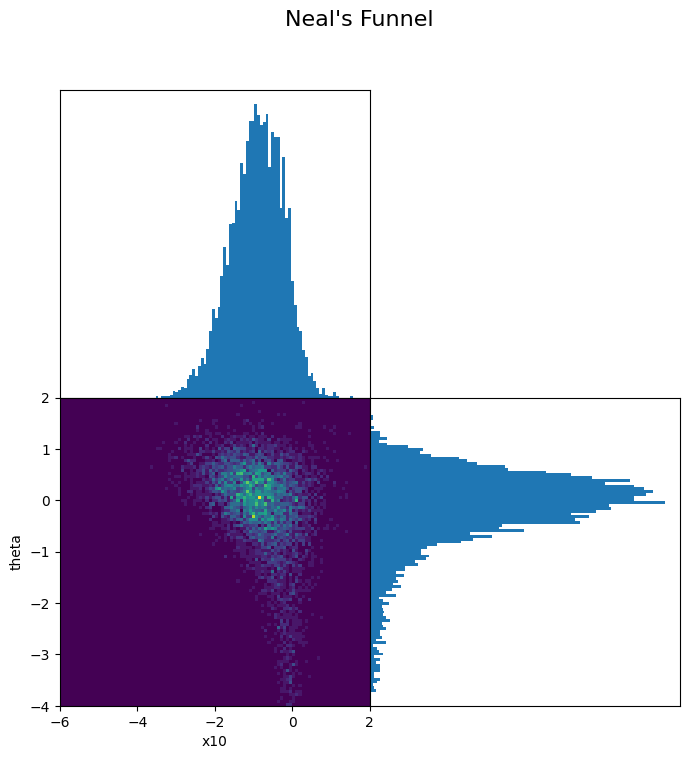

In [39]:
fig, axis = plt.subplots(2, 2, figsize=(8,8))
fig.suptitle("Neal's Funnel", fontsize=16)

fig.delaxes(axis[1,2])
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)

axis[1,1].hist(x10_mchmc, bins=100, range=[-6,2])
axis[1,1].set_yticks([])

axis[2,2].hist(theta_mchmc, bins=100, orientation="horizontal", range=[-4, 2])
axis[2,2].set_xticks([])
axis[2,2].set_yticks([])

axis[2,1].hist2d(x10_mchmc, theta_mchmc, bins=100, range=[[-6,2],[-4, 2]])
axis[2,1].set_xlabel("x10")
axis[2,1].set_ylabel("theta");

## Sampling w Turing

In [ ]:
using Turing

In [ ]:
TAP = 0.95
nadapts = 300
spl = Turing.NUTS(nadapts, TAP)

In [ ]:
Turing.sample(funnel_model, spl, 50_000, progress=true; save_state=true)